In [1]:
from ipynb.fs.full.feature_engineering_clustering import X_Transformer
from ipynb.fs.full.feature_engineering_clustering import TargetNormalizedRegressor
import pandas as pd
from ipynb.fs.full.feature_engineering_clustering import DataLoader
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import numpy.ma as ma
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import seaborn as sns
from mlxtend.evaluate import paired_ttest_5x2cv
from random import randint
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from xgboost import plot_importance
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [2]:
def rmsle(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(mean_squared_log_error(y_true, y_pred, sample_weight, multioutput))
    
#I just want to make rmse positive
flipped_score = make_scorer(rmsle, greater_is_better=True)

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),scoring=None):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
data_loader = DataLoader("train.csv","test.csv")

/home/victor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/victor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [5]:
X_train = data_loader.getX_train()
X_test = data_loader.getX_test()
Y_train = data_loader.getY_train()

In [6]:
x_transformer = X_Transformer()

/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [7]:
X_train = x_transformer.fit_transform(X_train,Y_train)
X_test = x_transformer.transform(X_test)
kf = KFold(n_splits=10,shuffle = True,random_state = 25)

/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


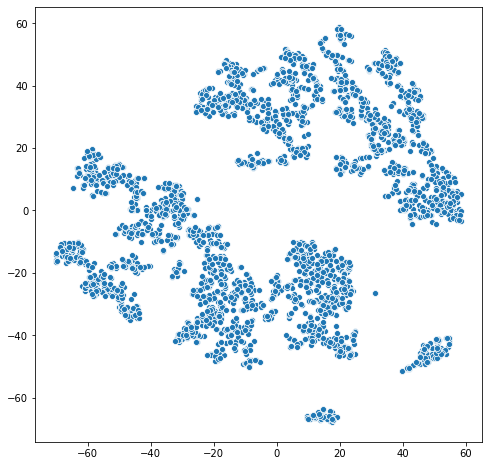

In [8]:
plt.figure(figsize=(8,8))
tsn = TSNE(random_state=20)
res_tsne = tsn.fit_transform(pd.concat([X_train, X_test]))
sns.scatterplot(res_tsne[:,0],res_tsne[:,1]);

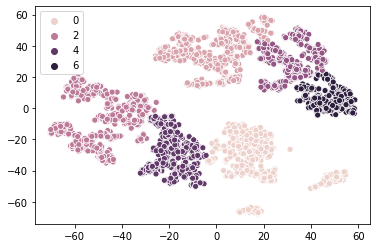

In [9]:
cl = AgglomerativeClustering(n_clusters = 6)
cl.fit(res_tsne)
sns.scatterplot(res_tsne[:,0],res_tsne[:,1],hue = cl.labels_);

In [10]:
labels = pd.DataFrame(cl.labels_)

In [11]:
labels_train = labels.iloc[:X_train.shape[0]]
labels_test = labels.iloc[X_train.shape[0]:]

In [12]:
new_train = pd.read_csv("train.csv")
new_test = pd.read_csv("test.csv")

In [13]:
new_train = new_train[new_train.GrLivArea < 4500]
new_train.reset_index(drop=True, inplace=True)
outliers = [30, 88, 462, 631, 1322]
new_train = new_train.drop(new_train.index[outliers])
new_train.reset_index(drop=True, inplace=True)
new_train = new_train[new_train.GarageArea < 1200]
new_train.reset_index(drop=True, inplace=True)

In [14]:
new_train.insert(1,'cluster',labels_train) 
new_test.insert(1,'cluster',labels_test) 

In [15]:
#new_train['cluster'] = new_train['cluster'].apply(lambda x: 2 if x==4 else x+1 if (x==2 or x==3) else x)
#new_test['cluster'] = new_test['cluster'].apply(lambda x: 2 if x==4 else x+1 if (x==2 or x==3) else x)

In [16]:
new_train['cluster'] = new_train['cluster'].apply(lambda x: 0 if x==0 else 1 if x==1 else 2 if x==4 else 3 if x==3 else 4 if x==2 else 5).astype(str)
new_test['cluster'] = new_test['cluster'].apply(lambda x: 0 if x==0 else 1 if x==1 else 2 if x==4 else 3 if x==3 else 4 if x==2 else 5).astype(str)

In [17]:
#new_train['cluster'] = new_train['cluster'].astype(str)
#new_test['cluster'] = new_test['cluster'].astype(str)

In [18]:
new_train.to_csv('train_cluster_str.csv',index = False)
new_test.to_csv('test_cluster_str.csv',index = False)

In [20]:
new_test['cluster']

0       5
1       5
2       5
3       5
4       5
       ..
1454    3
1455    2
1456    3
1457    2
1458    2
Name: cluster, Length: 1459, dtype: object